<a href="https://colab.research.google.com/github/Ivan-Nebogatikov/HumanActivityRecognition/blob/master/Open_Dataset_processing_all_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачиваем и разбираем данные

In [1]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from datetime import date
from math import sqrt

def getValue(x):
    l = list(json.loads(x.replace('\'', '"')))
    return l

def getDiff(x):
    res = list()
    for i, v in enumerate(x):
        res.append(v)
        #if i > 0:
        #    res.append(v - x[i - 1])
        #else:
        #    res.append(0)
    return res

heart = pd.read_csv('https://raw.githubusercontent.com/Ivan-Nebogatikov/HumanActivityRecognition/master/datasets/2282_3888_bundle_archive/heart.csv')
heart['timestamp'] = heart['timestamp'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
heart = heart.sort_values(by='timestamp')

def getHeart(x):
    dt = datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
    f = heart[heart['timestamp'] < dt]
    lastValue = f.iloc[[-1]]['values'].tolist()[0]
    intValue = list(json.loads(lastValue.replace('\'', '"')))[0]
    return intValue

acc = pd.read_csv('https://raw.githubusercontent.com/Ivan-Nebogatikov/HumanActivityRecognition/master/datasets/2282_3888_bundle_archive/acc.csv')
acc['heart'] = acc['timestamp'].map(lambda x: getHeart(x))
print(acc)

def change(x):
    if x == 'Pause' or x == 'Movie':
        x = 'Watching TV'
    if x == 'Shop':
        x = 'Walk'
    if x == 'Football':
        x = 'Running'
    if x == 'Meeting' or x == 'Work' or x == 'Picnic ' or x == 'In vehicle' or x == 'In bus' :
        x = 'Sitting'
    if x == 'On bus stop':
        x = 'Walk'
    if x == 'Walking&party' or x == 'Shopping& wearing' or x == 'At home':
        x = 'Walk'
    return x
acc['act'] = acc['act'].map(lambda x: change(x))

labels = np.array(acc['act'])

arrays = acc['values'].map(lambda x: getValue(x))
x = getDiff(list(arrays.map(lambda x: np.double(x[0]))))
y = getDiff(list(arrays.map(lambda x: np.double(x[1]))))
z = getDiff(list(arrays.map(lambda x: np.double(x[2]))))
dist = list(map(lambda a, b, c: sqrt(a*a+b*b+c*c), x, y, z))


      Unnamed: 0   index  ...     act heart
0           5022  169370  ...     Eat  79.0
1           5030  169379  ...     Eat  76.0
2           5048  169397  ...     Eat  72.0
3           5067  169416  ...     Eat  71.0
4           5084  169433  ...     Eat  71.0
...          ...     ...  ...     ...   ...
4737      172492  136369  ...  In bus  73.0
4738      172501  136379  ...  In bus  70.0
4739      172509  136387  ...  In bus  72.0
4740      172514  136392  ...  In bus  73.0
4741      172525  136403  ...  In bus  72.0

[4742 rows x 7 columns]


Вспомогательная функция для вывода результатов

In [3]:
import pandas as pd
import numpy as np
from scipy import interp

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = 5
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    print(class_report_df)
    return accuracy

Определяем функции для предсказания с использованием классификатора и с использованием нескольких классификаторов

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def Predict(x, classifier = RandomForestClassifier(n_estimators = 400, random_state = 3, class_weight='balanced')):
    train_features, test_features, train_labels, test_labels = train_test_split(x, labels, test_size = 0.15, random_state = 242)
    print('Training Features Shape:', train_features.shape)
    print('Testing Features Shape:', test_features.shape)
    print("\n")

    classifier.fit(train_features, train_labels);

    x_shuffled, labels_shuffled = shuffle(np.array(x), np.array(labels))

    scores = cross_val_score(classifier, x_shuffled, labels_shuffled, cv=7)
    print("%f accuracy with a standard deviation of %f" % (scores.mean(), scores.std()))

    predictions = list(classifier.predict(test_features))
    pred_prob = classifier.predict_proba(test_features)
    
    accuracy = class_report(
    y_true=test_labels,
    y_pred=np.asarray(predictions),
    y_score=pred_prob, average='micro')

    if hasattr(classifier, 'feature_importances_'):
        print(classifier.feature_importances_)

    plot_confusion_matrix(classifier, test_features, test_labels)
    plt.xticks(rotation = 90)
    plt.style.library['seaborn-darkgrid']
    plt.show()

    return [accuracy, scores.mean(), scores.std()]

def PredictWithClassifiers(data, classifiers):
    accuracies = {}
    for name, value in classifiers.items():
        accuracy = Predict(data, value)
        accuracies[name] = accuracy
        print("\n")
    df = pd.DataFrame({(k, v[0], v[1], v[2]) for k, v in accuracies.items()}, columns=["Method", "Accuracy", "Mean", "Std"])
    print(df)

Определяем набор используемых классификаторов

In [17]:
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier

methods = {
    "MLP" : MLPClassifier(random_state=1, max_iter=300),
    "K-neigh" : KNeighborsClassifier(), # default k = 5
    "Random Forest" : RandomForestClassifier(n_estimators = 400, random_state = 3, class_weight='balanced'),
    "Bayes" : GaussianNB(),
    "AdaBoost" : AdaBoostClassifier(),
    "SVM" : svm.SVC(probability=True, class_weight='balanced')
}

Предсказываем, используя только данные сердцебиения

         h
0     79.0
1     76.0
2     72.0
3     71.0
4     71.0
...    ...
4737  73.0
4738  70.0
4739  72.0
4740  73.0
4741  72.0

[4742 rows x 1 columns]
Training Features Shape: (4030, 1)
Testing Features Shape: (712, 1)


0.318434 accuracy with a standard deviation of 0.01
Accuracy: 0.28651685393258425
             precision    recall  f1-score  support   pred       AUC
Eat           0.750000  0.055556  0.103448     54.0    4.0  0.542328
Walk          0.283898  1.000000  0.442244    201.0  708.0  0.424059
avg / total   0.137027  0.286517  0.132693    255.0  255.0  0.783868


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


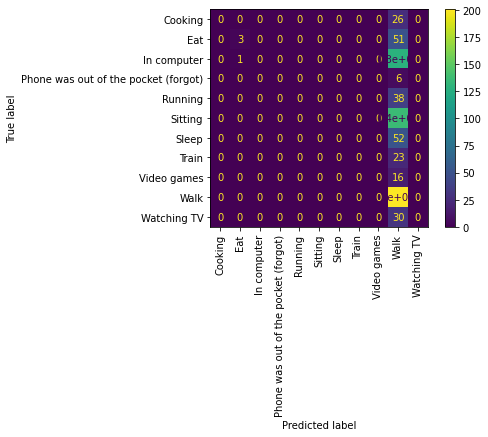



Training Features Shape: (4030, 1)
Testing Features Shape: (712, 1)


0.263180 accuracy with a standard deviation of 0.02
Accuracy: 0.23735955056179775
             precision    recall  f1-score  support   pred       AUC
Cooking       0.058824  0.038462  0.046512     26.0   17.0  0.614235
Eat           0.238095  0.092593  0.133333     54.0   21.0  0.638326
In computer   0.248227  0.271318  0.259259    129.0  141.0  0.570618
Running       0.612903  0.500000  0.550725     38.0   31.0  0.500000
Sitting       0.173184  0.226277  0.196203    137.0  179.0  0.479365
Sleep         0.083333  0.038462  0.052632     52.0   24.0  0.462252
Train         0.033333  0.086957  0.048193     23.0   60.0  0.481353
Walk          0.309623  0.368159  0.336364    201.0  239.0  0.519725
avg / total   0.225785  0.237360  0.226286    660.0  660.0  0.679124


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


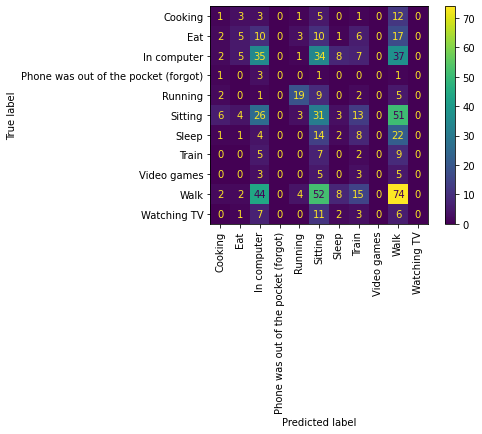



Training Features Shape: (4030, 1)
Testing Features Shape: (712, 1)


0.138973 accuracy with a standard deviation of 0.02
Accuracy: 0.14747191011235955
                                      precision    recall  ...   pred       AUC
Cooking                                0.171429  0.230769  ...   35.0  0.750000
Eat                                    0.189189  0.259259  ...   74.0  0.683665
In computer                            0.250000  0.093023  ...   48.0  0.565559
Phone was out of the pocket (forgot)   0.019868  0.500000  ...  151.0  0.691572
Running                                0.594595  0.578947  ...   37.0  0.879178
Sitting                                0.290323  0.065693  ...   31.0  0.593627
Sleep                                  0.265823  0.403846  ...   79.0  0.693415
Train                                  0.064935  0.217391  ...   77.0  0.639364
Video games                            0.000000  0.000000  ...   64.0  0.607804
Walk                                   0.80000

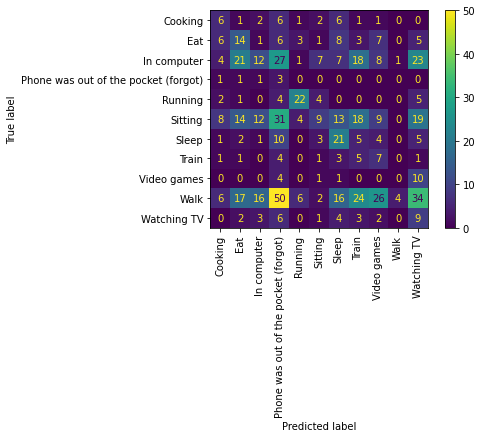



Training Features Shape: (4030, 1)
Testing Features Shape: (712, 1)


0.309574 accuracy with a standard deviation of 0.02
Accuracy: 0.2907303370786517
             precision    recall  f1-score  support   pred       AUC
Running       0.647059  0.289474  0.400000     38.0   17.0  0.634332
Walk          0.282014  0.975124  0.437500    201.0  695.0  0.473761
avg / total   0.114148  0.290730  0.144856    239.0  239.0  0.782405


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


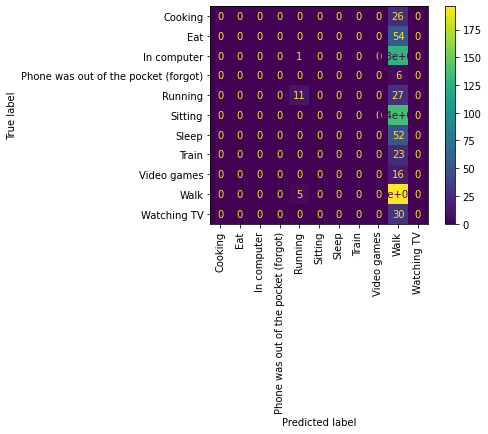



Training Features Shape: (4030, 1)
Testing Features Shape: (712, 1)


0.326023 accuracy with a standard deviation of 0.01
Accuracy: 0.3089887640449438
             precision    recall  f1-score  support   pred       AUC
Eat           0.750000  0.055556  0.103448     54.0    4.0  0.516394
Running       0.568182  0.657895  0.609756     38.0   44.0  0.773680
Walk          0.289157  0.955224  0.443931    201.0  664.0  0.478245
avg / total   0.168836  0.308989  0.165712    293.0  293.0  0.753155
[1.]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


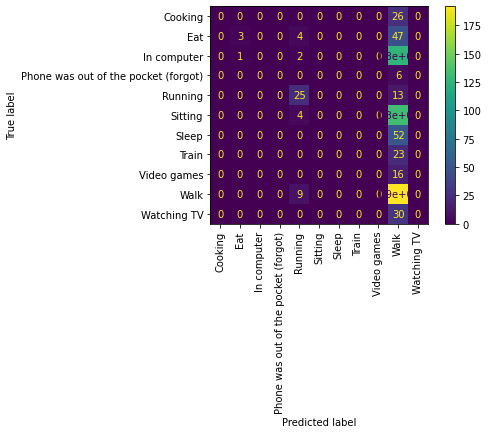



Training Features Shape: (4030, 1)
Testing Features Shape: (712, 1)


0.112613 accuracy with a standard deviation of 0.01
Accuracy: 0.11657303370786516
                                      precision    recall  ...   pred       AUC
Cooking                                0.157895  0.346154  ...   57.0  0.718883
Eat                                    0.130435  0.166667  ...   69.0  0.623157
Phone was out of the pocket (forgot)   0.007194  0.166667  ...  139.0  0.533522
Running                                0.625000  0.657895  ...   40.0  0.140032
Sleep                                  0.226667  0.326923  ...   75.0  0.505944
Train                                  0.044118  0.260870  ...  136.0  0.637376
Walk                                   1.000000  0.019900  ...    4.0  0.568113
Watching TV                            0.062500  0.400000  ...  192.0  0.488368
avg / total                            0.351992  0.116573  ...  430.0  0.795344

[9 rows x 6 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


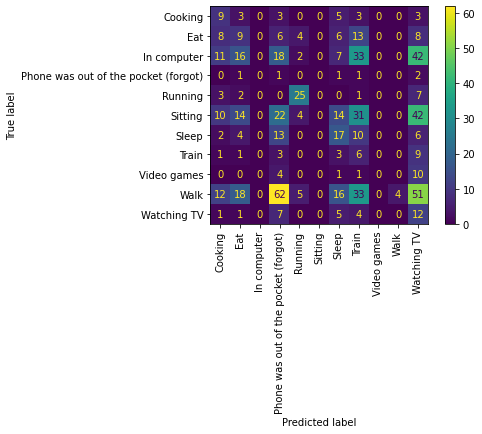



          Method  Accuracy      Mean       Std
0        K-neigh  0.237360  0.263180  0.021682
1            MLP  0.286517  0.318434  0.007377
2       AdaBoost  0.308989  0.326023  0.009540
3  Random Forest  0.147472  0.138973  0.016913
4            SVM  0.116573  0.112613  0.012103
5          Bayes  0.290730  0.309574  0.016740


In [18]:
frame = pd.DataFrame(list(acc['heart']), columns=['h'])
feature_list = list(frame.columns)
print(frame)

PredictWithClassifiers(frame, methods)

Предсказываем, используя только данные акселерометра

              x          y         z
0    -10.173126  -1.471237  1.924393
1      4.726227 -10.251968  0.491104
2    -10.776581  -0.819656 -0.581741
3    -10.300018  -1.300781  0.812164
4     -8.121658  -0.150238 -0.705032
...         ...        ...       ...
4737  -9.694046  -1.125046  2.037765
4738 -10.787354  -2.289215  1.636612
4739  -4.396042  -7.009506  2.160950
4740  -9.635635   1.458542 -0.267487
4741  -5.556152  -7.290588 -2.863174

[4742 rows x 3 columns]
Training Features Shape: (4030, 3)
Testing Features Shape: (712, 3)




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.380641 accuracy with a standard deviation of 0.01
Accuracy: 0.3693820224719101
             precision    recall  f1-score  support   pred       AUC
Cooking       0.333333  0.038462  0.068966     26.0    3.0  0.840715
In computer   0.395062  0.248062  0.304762    129.0   81.0  0.387796
Running       0.444444  0.105263  0.170213     38.0    9.0  0.426831
Sitting       0.414894  0.284672  0.337662    137.0   94.0  0.574675
Sleep         0.541667  0.250000  0.342105     52.0   24.0  0.421911
Train         0.666667  0.173913  0.275862     23.0    6.0  0.436108
Walk          0.338843  0.815920  0.478832    201.0  484.0  0.459298
Watching TV   0.545455  0.200000  0.292683     30.0   11.0  0.685435
avg / total   0.367037  0.369382  0.313196    636.0  636.0  0.828836


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


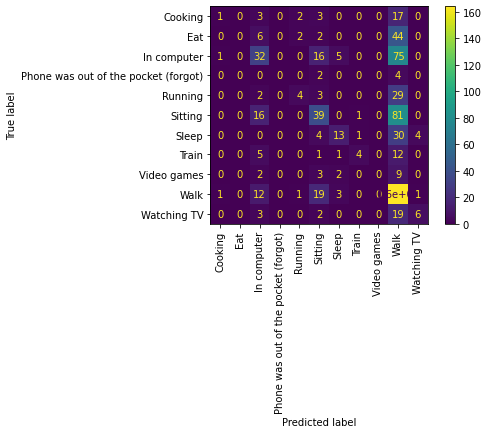



Training Features Shape: (4030, 3)
Testing Features Shape: (712, 3)


0.417544 accuracy with a standard deviation of 0.01
Accuracy: 0.4199438202247191
                                      precision    recall  ...   pred       AUC
Cooking                                0.185185  0.192308  ...   27.0  0.625589
Eat                                    0.394737  0.277778  ...   38.0  0.705294
In computer                            0.433333  0.503876  ...  150.0  0.716529
Phone was out of the pocket (forgot)   0.000000  0.000000  ...    1.0  0.488669
Running                                0.409091  0.236842  ...   22.0  0.649715
Sitting                                0.410072  0.416058  ...  139.0  0.696630
Sleep                                  0.735849  0.750000  ...   53.0  0.879108
Train                                  0.360000  0.391304  ...   25.0  0.800940
Video games                            0.263158  0.312500  ...   19.0  0.788344
Walk                                   0.401826

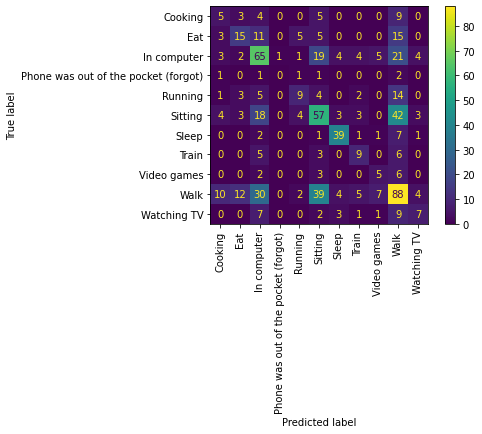



Training Features Shape: (4030, 3)
Testing Features Shape: (712, 3)


0.456351 accuracy with a standard deviation of 0.01
Accuracy: 0.42837078651685395
                                      precision    recall  ...   pred       AUC
Cooking                                0.250000  0.115385  ...   12.0  0.792779
Eat                                    0.393939  0.240741  ...   33.0  0.780057
In computer                            0.457364  0.457364  ...  129.0  0.770287
Phone was out of the pocket (forgot)   0.000000  0.000000  ...    1.0  0.713645
Running                                0.357143  0.131579  ...   14.0  0.815145
Sitting                                0.414062  0.386861  ...  128.0  0.720457
Sleep                                  0.822222  0.711538  ...   45.0  0.911407
Train                                  0.380952  0.347826  ...   21.0  0.799205
Video games                            0.384615  0.312500  ...   13.0  0.771417
Walk                                   0.37417

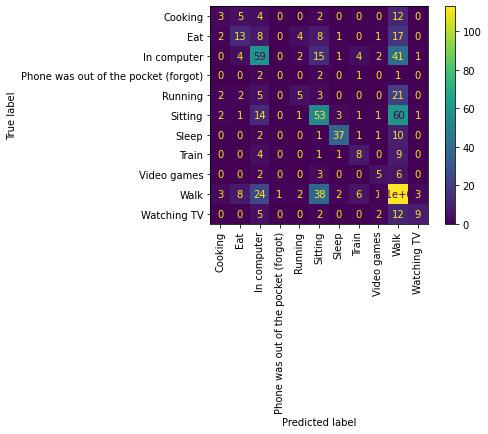



Training Features Shape: (4030, 3)
Testing Features Shape: (712, 3)


0.297131 accuracy with a standard deviation of 0.02
Accuracy: 0.2710674157303371
             precision    recall  f1-score  support   pred       AUC
In computer   0.164179  0.085271  0.112245    129.0   67.0  0.406265
Running       0.125000  0.026316  0.043478     38.0    8.0  0.671287
Sitting       0.266667  0.058394  0.095808    137.0   30.0  0.496795
Walk          0.285008  0.860697  0.428218    201.0  607.0  0.527130
avg / total   0.168187  0.271067  0.161979    505.0  505.0  0.786244


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


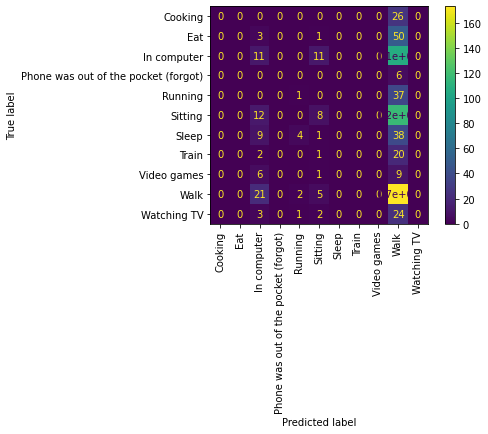



Training Features Shape: (4030, 3)
Testing Features Shape: (712, 3)


0.293760 accuracy with a standard deviation of 0.02
Accuracy: 0.2752808988764045
                                      precision    recall  ...   pred       AUC
Eat                                    0.285714  0.074074  ...   14.0  0.575833
In computer                            0.256410  0.155039  ...   78.0  0.506150
Phone was out of the pocket (forgot)   0.000000  0.000000  ...    6.0  0.508144
Running                                0.173913  0.105263  ...   23.0  0.514720
Sitting                                0.281046  0.313869  ...  153.0  0.471558
Sleep                                  0.666667  0.038462  ...    3.0  0.439248
Train                                  0.050000  0.173913  ...   80.0  0.659021
Walk                                   0.345930  0.592040  ...  344.0  0.488930
Watching TV                            0.000000  0.000000  ...   11.0  0.652786
avg / total                            0.279447

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


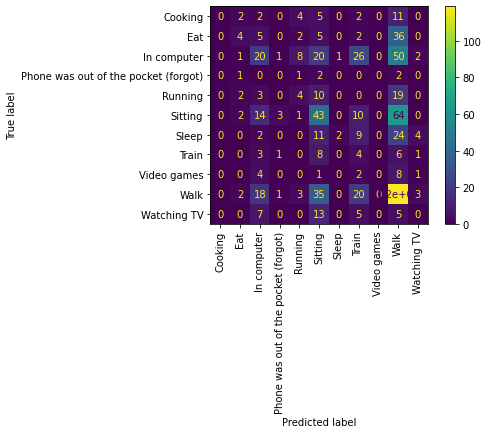



Training Features Shape: (4030, 3)
Testing Features Shape: (712, 3)


0.138756 accuracy with a standard deviation of 0.02
Accuracy: 0.13764044943820225
                                      precision    recall  ...   pred       AUC
Cooking                                0.152174  0.269231  ...   46.0  0.799170
Eat                                    0.147727  0.240741  ...   88.0  0.715946
In computer                            0.482759  0.108527  ...   29.0  0.652546
Phone was out of the pocket (forgot)   0.017751  0.500000  ...  169.0  0.704674
Running                                0.203704  0.289474  ...   54.0  0.749258
Sitting                                0.260870  0.043796  ...   23.0  0.610981
Sleep                                  0.315068  0.442308  ...   73.0  0.793328
Train                                  0.030769  0.086957  ...   65.0  0.720263
Video games                            0.019608  0.125000  ...  102.0  0.699802
Walk                                   0.46153

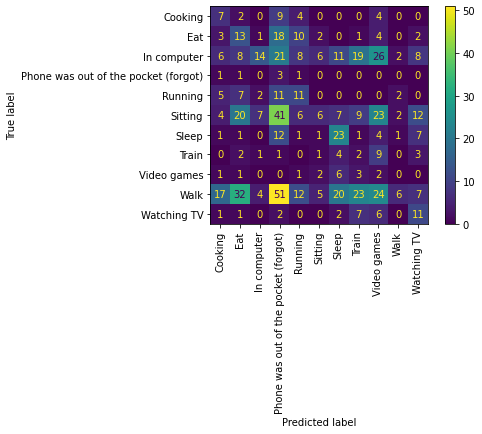



          Method  Accuracy      Mean       Std
0            MLP  0.369382  0.380641  0.012321
1            SVM  0.137640  0.138756  0.015060
2       AdaBoost  0.275281  0.293760  0.019581
3        K-neigh  0.419944  0.417544  0.010424
4  Random Forest  0.428371  0.456351  0.013422
5          Bayes  0.271067  0.297131  0.016366


In [19]:
frame = pd.DataFrame(zip(x, y, z), columns=['x', 'y', 'z'])
feature_list = list(frame.columns)
print(frame)

PredictWithClassifiers(frame, methods)

Предсказываем, используя данные обоих датчиков

         h          x          y         z
0     79.0 -10.173126  -1.471237  1.924393
1     76.0   4.726227 -10.251968  0.491104
2     72.0 -10.776581  -0.819656 -0.581741
3     71.0 -10.300018  -1.300781  0.812164
4     71.0  -8.121658  -0.150238 -0.705032
...    ...        ...        ...       ...
4737  73.0  -9.694046  -1.125046  2.037765
4738  70.0 -10.787354  -2.289215  1.636612
4739  72.0  -4.396042  -7.009506  2.160950
4740  73.0  -9.635635   1.458542 -0.267487
4741  72.0  -5.556152  -7.290588 -2.863174

[4742 rows x 4 columns]
Training Features Shape: (4030, 4)
Testing Features Shape: (712, 4)


0.371990 accuracy with a standard deviation of 0.01
Accuracy: 0.3693820224719101
             precision    recall  f1-score  support   pred       AUC
Eat           0.750000  0.055556  0.103448     54.0    4.0  0.618822
In computer   0.381679  0.387597  0.384615    129.0  131.0  0.403819
Running       0.533333  0.210526  0.301887     38.0   15.0  0.375527
Sitting       0.353448  0.299270

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


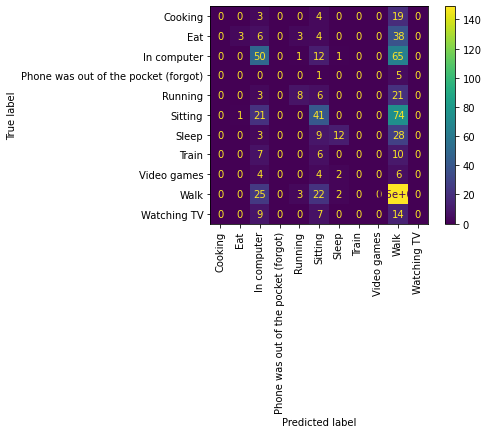



Training Features Shape: (4030, 4)
Testing Features Shape: (712, 4)


0.449387 accuracy with a standard deviation of 0.02
Accuracy: 0.4339887640449438
             precision    recall  f1-score  support   pred       AUC
Cooking       0.290323  0.346154  0.315789     26.0   31.0  0.838949
Eat           0.363636  0.296296  0.326531     54.0   44.0  0.718099
In computer   0.392857  0.426357  0.408922    129.0  140.0  0.710984
Running       0.718750  0.605263  0.657143     38.0   32.0  0.483680
Sitting       0.403846  0.459854  0.430034    137.0  156.0  0.494186
Sleep         0.666667  0.615385  0.640000     52.0   48.0  0.348266
Train         0.291667  0.304348  0.297872     23.0   24.0  0.529312
Video games   0.200000  0.062500  0.095238     16.0    5.0  0.546336
Walk          0.434579  0.462687  0.448193    201.0  214.0  0.505262
Watching TV   0.555556  0.333333  0.416667     30.0   18.0  0.463978
avg / total   0.434122  0.433989  0.430789    706.0  706.0  0.817250


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


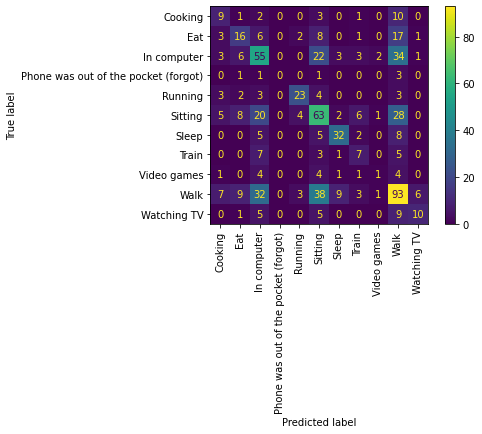



Training Features Shape: (4030, 4)
Testing Features Shape: (712, 4)


0.512653 accuracy with a standard deviation of 0.01
Accuracy: 0.5014044943820225
             precision    recall  f1-score  support   pred       AUC
Cooking       0.476190  0.384615  0.425532     26.0   21.0  0.898716
Eat           0.407407  0.203704  0.271605     54.0   27.0  0.830646
In computer   0.533333  0.496124  0.514056    129.0  120.0  0.821785
Running       0.741935  0.605263  0.666667     38.0   31.0  0.436221
Sitting       0.480620  0.452555  0.466165    137.0  129.0  0.507921
Sleep         0.813953  0.673077  0.736842     52.0   43.0  0.194624
Train         0.444444  0.347826  0.390244     23.0   18.0  0.594182
Video games   0.400000  0.125000  0.190476     16.0    5.0  0.624192
Walk          0.438944  0.661692  0.527778    201.0  303.0  0.534685
Watching TV   0.600000  0.300000  0.400000     30.0   15.0  0.450073
avg / total   0.508982  0.501404  0.491101    706.0  706.0  0.894969
[0.24010366 0.25892

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


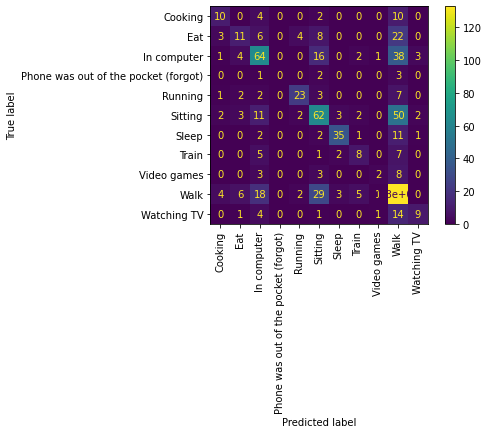



Training Features Shape: (4030, 4)
Testing Features Shape: (712, 4)


0.311471 accuracy with a standard deviation of 0.01
Accuracy: 0.300561797752809
             precision    recall  f1-score  support   pred       AUC
In computer   0.259259  0.325581  0.288660    129.0  162.0  0.440252
Running       0.520000  0.342105  0.412698     38.0   25.0  0.639817
Sitting       0.273333  0.299270  0.285714    137.0  150.0  0.525852
Walk          0.315508  0.587065  0.410435    201.0  374.0  0.554965
Watching TV   0.000000  0.000000  0.000000     30.0    1.0  0.270772
avg / total   0.216388  0.300562  0.245168    535.0  535.0  0.795197


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


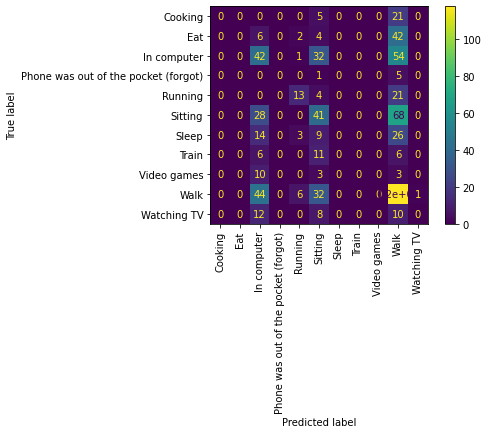



Training Features Shape: (4030, 4)
Testing Features Shape: (712, 4)


0.280902 accuracy with a standard deviation of 0.02
Accuracy: 0.2893258426966292
             precision    recall  f1-score  support   pred       AUC
Cooking       0.077778  0.269231  0.120690     26.0   90.0  0.690710
Eat           0.750000  0.055556  0.103448     54.0    4.0  0.605651
In computer   0.231481  0.193798  0.210970    129.0  108.0  0.579833
Running       0.303030  0.263158  0.281690     38.0   33.0  0.205177
Sitting       0.341176  0.211679  0.261261    137.0   85.0  0.494916
Sleep         0.000000  0.000000  0.000000     52.0    7.0  0.407401
Train         0.076923  0.043478  0.055556     23.0   13.0  0.595002
Video games   0.000000  0.000000  0.000000     16.0    4.0  0.609914
Walk          0.348901  0.631841  0.449558    201.0  364.0  0.537021
Watching TV   1.000000  0.133333  0.235294     30.0    4.0  0.488148
avg / total   0.326598  0.289326  0.254402    706.0  706.0  0.725043
[0.24 0.28 0.24 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


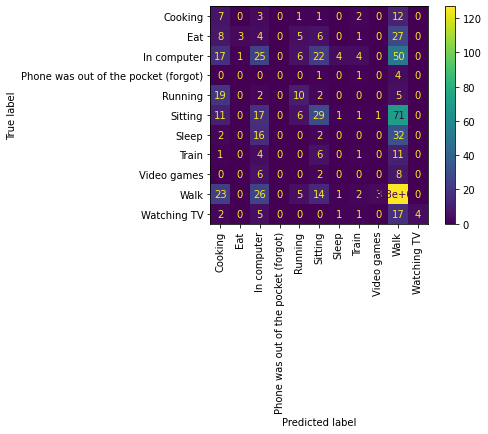



Training Features Shape: (4030, 4)
Testing Features Shape: (712, 4)


0.123578 accuracy with a standard deviation of 0.01
Accuracy: 0.14325842696629212
                                      precision    recall  ...   pred       AUC
Cooking                                0.238095  0.384615  ...   42.0  0.720677
Eat                                    0.147727  0.240741  ...   88.0  0.681386
In computer                            0.250000  0.007752  ...    4.0  0.625766
Phone was out of the pocket (forgot)   0.015306  0.500000  ...  196.0  0.705619
Running                                0.568182  0.657895  ...   44.0  0.879666
Sitting                                0.000000  0.000000  ...    1.0  0.575030
Sleep                                  0.307692  0.384615  ...   65.0  0.714948
Train                                  0.049180  0.130435  ...   61.0  0.668770
Video games                            0.072072  0.500000  ...  111.0  0.699892
Walk                                   0.52173

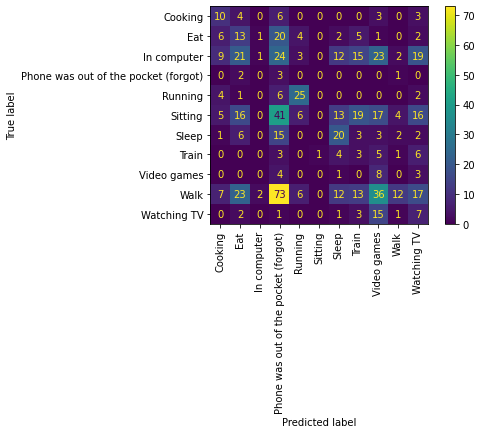



          Method  Accuracy      Mean       Std
0        K-neigh  0.433989  0.449387  0.015624
1            MLP  0.369382  0.371990  0.013564
2       AdaBoost  0.289326  0.280902  0.024747
3  Random Forest  0.501404  0.512653  0.007842
4            SVM  0.143258  0.123578  0.009474
5          Bayes  0.300562  0.311471  0.006189


In [20]:
frame = pd.DataFrame(zip(list(acc['heart']), x, y, z), columns=['h', 'x', 'y', 'z'])
feature_list = list(frame.columns)
print(frame)

PredictWithClassifiers(frame, methods)